# BETO model

In [1]:
import pandas as pd

## Datos

### Senators_data

In [2]:
#Import senator csv from senator_data_file
senators = pd.read_csv(r'/Users/mimihuerta/code/jomilu93/sivico/senators_data.csv', converters={'initiative_list': pd.eval}, index_col='Unnamed: 0')
senators.head(2)

,senator_id,Apellidos,Nombre,Fraccion,Legislatura,Estado,Sexo,tipoEleccion,Suplente,estadoOrigen,...,url_sitio,telefono,extension,estatus,direccion,id,senadores,attendance_score,initiative_list,initiatives_summary_dummy
0,1160,Botello Montes,José Alfredo,PAN,64,Querétaro,Hombre,Senador Electo por el Principio de Mayoría Rel...,NaN,Querétaro,...,NaN,5345 3000,4183 y 4184,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",1,José Alfredo Botello Montes,0.958904,[Pretende garantizar a los miembros del Servic...,Pretende garantizar a los miembros del Servici...
1,1162,Rojas Loreto,Estrella,PAN,64,Querétaro,Mujer,Senadora Electa por el Principio de Mayoría Re...,NaN,Querétaro,...,NaN,5345 3000,3323,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",2,Estrella Rojas Loreto,0.973913,[Propone que el Estado apoye la investigación ...,Propone que el Estado apoye la investigación e...


In [9]:
type(senators['initiative_list'])

pandas.core.series.Series

In [10]:
#Dataset column names
columnas = senators.columns
columnas

Index(['senator_id', 'Apellidos', 'Nombre', 'Fraccion', 'Legislatura',
       'Estado', 'Sexo', 'tipoEleccion', 'Suplente', 'estadoOrigen', 'correo',
       'facebook', 'twitter', 'youtube', 'instagram', 'url_sitio', 'telefono',
       'extension', 'estatus', 'direccion', 'id', 'senadores',
       'attendance_score', 'initiative_list', 'initiatives_summary_dummy'],
      dtype='object')

<Axes: >

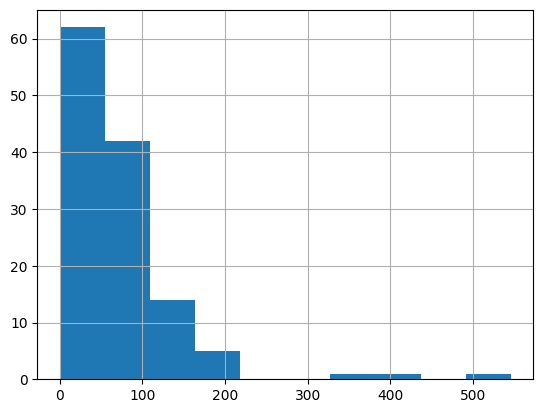

In [32]:
#Number of sentences in the dataset
len_col = [len(prop) for prop in senators["initiative_list"]]
pd.Series(len_col).hist()

<Axes: >

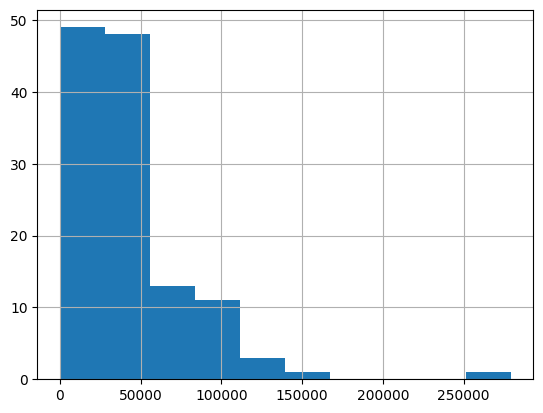

In [38]:
#Number of words in the dataset
len_col = [len(str(prop)) for prop in senators['initiatives_summary_dummy']]
               
pd.Series(len_col).hist()

In [135]:
#Split the concatenated initiatives for each senator into bites smaller than 511 to be able to consider inside the model.
senators["initiatives_summary_dummy_split"] = ""

n = 511

for i, row in senators.iterrows():
    if not row["initiative_list"] == []:
        initiatives_split = [row["initiatives_summary_dummy"][i:i+n] for i in range(0, len(row["initiatives_summary_dummy"]), n)]
        senators.at[i, "initiatives_summary_dummy_split"] = initiatives_split
    else:
        senators.at[i, "initiatives_summary_dummy_split"] = []

In [145]:
senators.head(2)

,senator_id,Apellidos,Nombre,Fraccion,Legislatura,Estado,Sexo,tipoEleccion,Suplente,estadoOrigen,...,extension,estatus,direccion,id,senadores,attendance_score,initiative_list,initiatives_summary_dummy,BETO,initiatives_summary_dummy_split
0,1160,Botello Montes,José Alfredo,PAN,64,Querétaro,Hombre,Senador Electo por el Principio de Mayoría Rel...,NaN,Querétaro,...,4183 y 4184,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",1,José Alfredo Botello Montes,0.958904,[Pretende garantizar a los miembros del Servic...,Pretende garantizar a los miembros del Servici...,,[Pretende garantizar a los miembros del Servic...
1,1162,Rojas Loreto,Estrella,PAN,64,Querétaro,Mujer,Senadora Electa por el Principio de Mayoría Re...,NaN,Querétaro,...,3323,en_funciones,"Av Paseo de la Reforma No. 135, Hemiciclo Piso...",2,Estrella Rojas Loreto,0.973913,[Propone que el Estado apoye la investigación ...,Propone que el Estado apoye la investigación e...,,[Propone que el Estado apoye la investigación ...


In [158]:
len(senators['initiatives_summary_dummy_split'][0])

4

In [159]:
senators['initiatives_summary_dummy_split'][0]

['Pretende garantizar a los miembros del Servicio Exterior Mexicano, en un porcentaje mayor al que se establece en la legislación actual, el acceso a los cargos de representación del estado como Embajador o Cónsul.Propone establecer una mayor claridad en la subdivisión de las comisiones ordinarias de Educación, Cultura y Ciencia y Tecnología, suprimiendo la única denominación vigente de la comisión ordinaria de “Educación, Cultura, Ciencia y Tecnología”.Propone establecer que el instituto de Servicios Perici',
 'ales y Ciencias Forenses será el área técnica de apoyo a la Fiscalía que tendrá como objetivo fortalecer su capacidad institucional para realizar sus funciones de manera especializada y científica. Determina el establecimiento de un Servicio de Carrera Pericial.Propone establecer que las iniciativas ciudadanas tengan el carácter de preferente.Propone establecer que el Sistema Educativo Nacional considerará la educación en materia de privacidad y protección de sus datos personal

In [157]:
ex_i = (senators['initiative_list'][35][10])
ex_i

'Propone reformar el ordenamientos legales para garantizar la inclusión de pueblos y comunidades indígenas.\r\n'

In [155]:
ex_s = senators['initiatives_summary_dummy'][35]
len(ex_s)

154009

In [154]:
len(senators["initiatives_summary_dummy"][35])

154009

### Preprocess

In [ ]:
import string
from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

In [ ]:
def clean(column):
    """Remove punctuation, make strings lower case, remove numbers. Tokenize, remove stopwords and lemmatize."""
    #Removing punctuation.
    for punctuation in string.punctuation:
        column = column.apply(lambda x: x.replace(punctuation, ''))
    #Making lower case and removing whitespace.
    column = column.apply(lambda x: x.lower().strip())
    #Removing numbers
    column = column.apply(lambda x: re.sub(r'[0-9]', '', x))
    #Tokenize all rows.
    #column = column.apply(lambda x: word_tokenize(x))
    #Remove stopwords and words too frequently present in initiative language.
    stop_words = set(stopwords.words('spanish'))
    stop_words_extra = ("pretende", "propone", "exhorta", "modificar", "actualizar", "política", "general",
                        "caso", "derecho", "materia", "virtud", "referencias", "cambiar", "deberán", "día",
                        "año", "denominación", "distrito", "cámara", "senadores", "normativa", "senado",
                        "objetivo", "cumplimiento", "ordenamiento", "república", "reforma", "cada",
                        "dar", "federal", "secretaría", "mención", "paso", "dejar", "principio",
                        "ser", "paridad", "así", "derechos", "reformar", "propone", "nacional",
                        "establecer", "méxico", "persona", "ley", "ciudad", "deberá", "legal", "personas")
    column = column.apply(lambda x: [w for w in x if w not in stop_words])
    column = column.apply(lambda x: [w for w in x if w not in stop_words_extra])
    # Lemmatizing the verbs
    #column = column.apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos = "v") for word in x])
    # 2 - Lemmatizing the nouns
    #column = column.apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos = "n") for word in x])
    # Rejoin words to make sentences
    column = column.apply(lambda x: " ".join(x))
    return column

### Inipros

In [ ]:
data_ip = pd.read_csv("/Users/mimihuerta/code/jomilu93/sivico/inipros.csv", index_col='Unnamed: 0')

In [ ]:
print(data_ip.shape)
data_ip.head(2)

In [ ]:
eg1 = data_ip['sintesis'][7827]
eg1

In [ ]:
ip_column = data_ip["sintesis"]
ip_column

In [ ]:
len_col_ip = [len(prop_in.split()) for prop_in in ip_column]

pd.Series(len_col_ip).hist()

## Model

### Opción 1

In [77]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [54]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert2bert_shared-spanish-finetuned-summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/bert2bert_shared-spanish-finetuned-summarization")

The following encoder weights were not tied to the decoder ['bert/pooler']
Some weights of EncoderDecoderModel were not initialized from the model checkpoint at mrm8488/bert2bert_shared-spanish-finetuned-summarization and are newly initialized: ['decoder.bert.encoder.layer.9.attention.self.value.weight', 'decoder.bert.encoder.layer.5.output.LayerNorm.weight', 'decoder.bert.encoder.layer.2.output.dense.bias', 'decoder.bert.encoder.layer.3.output.LayerNorm.weight', 'decoder.bert.encoder.layer.9.output.LayerNorm.weight', 'decoder.bert.encoder.layer.1.attention.output.LayerNorm.weight', 'decoder.bert.encoder.layer.8.attention.output.dense.weight', 'decoder.bert.encoder.layer.0.output.LayerNorm.weight', 'decoder.bert.encoder.layer.0.intermediate.dense.bias', 'decoder.bert.encoder.layer.3.intermediate.dense.bias', 'decoder.bert.encoder.layer.7.attention.self.value.weight', 'decoder.bert.encoder.layer.10.attention.self.value.weight', 'decoder.bert.encoder.layer.1.attention.self.key.bias', 'de

The following encoder weights were not tied to the decoder ['bert/pooler']


In [148]:
inputs = tokenizer.encode("RESUMEN: " + ex_s, return_tensors="pt", max_length=511, truncation=True)
len(inputs[0])

511

In [149]:
resumen = model.generate(
    inputs, 
    max_length=10000,
    min_length=40, 
    length_penalty=2.0, 
    num_beams=4, 
    early_stopping=True)

In [134]:
print(tokenizer.decode(resumen[0]))

[CLS] Propone que el Estado apoye la investigación e innovación científica humanística y tecnológica y tecnológica, adicionándolas como áreas prioritarias para el desarrollo y la mejora de las condiciones laborales de la Ciudad de México [SEP]


In [168]:
prop_inc_t = senators['initiatives_summary_dummy_split']
prop_inc_t[0]

['Pretende garantizar a los miembros del Servicio Exterior Mexicano, en un porcentaje mayor al que se establece en la legislación actual, el acceso a los cargos de representación del estado como Embajador o Cónsul.Propone establecer una mayor claridad en la subdivisión de las comisiones ordinarias de Educación, Cultura y Ciencia y Tecnología, suprimiendo la única denominación vigente de la comisión ordinaria de “Educación, Cultura, Ciencia y Tecnología”.Propone establecer que el instituto de Servicios Perici',
 'ales y Ciencias Forenses será el área técnica de apoyo a la Fiscalía que tendrá como objetivo fortalecer su capacidad institucional para realizar sus funciones de manera especializada y científica. Determina el establecimiento de un Servicio de Carrera Pericial.Propone establecer que las iniciativas ciudadanas tengan el carácter de preferente.Propone establecer que el Sistema Educativo Nacional considerará la educación en materia de privacidad y protección de sus datos personal

In [183]:
def summarizeRow(prop_inc_t, resumentList, inputsList):
    for parag in prop_inc_t:
        inputs = tokenizer.encode(parag, return_tensors="pt", max_length=511, truncation=True)
        inputsList.append(inputs)
        resumen = model.generate(
            inputs, 
            max_length=200,
            min_length=40, 
            length_penalty=2.0, 
            num_beams=4, 
            early_stopping=True)
        resumentList.append(tokenizer.decode(resumen[0]))

resumentList = []
inputsList = []

summarizeRow(prop_inc_t[0], resumentList, inputsList)

In [182]:
for row in prop_inc_t[:5]:
    resumentList = []
    inputsList = []

    summarizeRow(row, resumentList, inputsList)
    
    print(inputsList)
    print(resumentList)

[tensor([[    4,  2583,  1223,  1006,  3976,  1013,  1065,  1923,  1072,  6368,
         26077, 15912,  1630,  1017,  1036,  1049,  7780,  1795,  1091,  1038,
          1062,  4205,  1036,  1030,  4348,  3627,  1017,  1040,  3209,  1013,
          1065,  7554,  1008,  6595,  1072,  1814,  1184, 13914,  1074, 19489,
          9455,  1257,  1009,  1685,  5299,  3952,  1108,  1795, 12404,  1036,
          1030, 15403,  2304,  1008,  1089, 10726, 28613,  1008,  6526,  1017,
          9488,  1042, 13022,  1042, 13494,  1017, 10756,  1360,  1030,  3476,
         10684,  8155,  1008,  1030,  6699, 17748,  1008,     3,  6526,  1017,
          9488,  1017, 13022,  1042, 13494,     3,  1009,  1685,  5299,  3952,
          1038,  1040, 12168,  1008,  6756, 28582,  1023,     5]]), tensor([[    4,  2249, 30934,  1042, 10686,  6422, 14942,  2218,  1040,  4378,
          4541,  1008,  2731,  1013,  1030, 22088,  1038,  4274,  1184,  3219,
          8362,  1079,  3201,  9809,  1110,  3335,  1287,  412

[tensor([[    4,  1685,  5299,  9308,  1089,  3262, 12407,  1019,  4461,  1013,
          1065,  4956, 22258,  1019,  1042,  4158,  1017,  1110,  3952,  1040,
          3434,  1008,  1080,  1441,  1008,  4345,  1036,  1079,  6061,   976,
          3138,  8235, 13810,  9294,  7999,  8214,  1036,  1089,  6448,  1009,
          1685,  5299,  3952,  1030,  9173,  1008,  5703,  1534,  1089,  1858,
          1051, 10241,  1036,  1030,  8382,  1008,  1397,  1932,  1008,  7187,
          1009,  1685,  5299,  3952,  1038,  1017,  1036,  1040,  1890,  1008,
          7100,  1017,  2330,  1042, 10557, 13017,  1084, 21410,  1074, 13687,
          1008,  1079,  2268,  1017,  1030,  5864,  1008, 23505,     5]]), tensor([[    4,  4280,  3976,  1373,  1040,  3209,  1013,  4472,  1036,  1065,
          1038,  4197,  1200, 14575,  1184,  7393,  1009,  1685,  5299,  3952,
          1038,  1030,  2598, 21435,  1096,  1030,  1575,  3283,  1008, 27878,
          1042,  4914,  4748,  2440,  1013, 17434,  428

[tensor([[    4,  1685,  5299,  7448,  1040, 11881,  1038,  4205,  1038,  1058,
          3061,  1038,  1065,  3426,  1008,  5585,  4481, 11160,  1096,  1114,
          1943,  1860,  1503,  1008,     3,  1036,  1040,  3785,  1017,  1110,
          2313,  4912,  6542,  1008,     3,  1036,  1890,  1008, 10749, 14497,
          1072,  1698,  1009,  1685,  5299,  7448,  1040,  3254,  1038, 12476,
          1038,  1486,  1062,  7820,  1013,  5564, 23900,  1042,  1040, 11817,
         17392,  6799,  1419,  1110,  4912, 23358,  1084,  7230,  1091,  1008,
          1030,  6290,  1017,  1062,  7820,  1013,  1030,  8517,  1096,  2383,
         10819,  1477,  1038,  1304,  1032,  3531,  1008,  7988,  1757,  1040,
          2278,  1038,  1008,     5]]), tensor([[    4,  2519,  3335,  1030,  5076,  1074,  7165,  3863,  1486,  1040,
          7874,  1506,  1114, 20452,  1009,  1685,  5299,  3952,  1038,  1065,
          3426,  9766,  1038,  1084, 17632, 18345, 30934,  1013, 15744,  1460,
          6

[tensor([[    4,  1685,  5299,  9308,  1089,  3262, 12407,  1019,  4461,  1013,
          1065,  4956, 22258,  1019,  1042,  4158,  1017,  1110,  3952,  1040,
          3434,  1008,  1080,  1441,  1008,  4345,  1036,  1079,  6061,   976,
          3138,  8235, 13810,  9294,  7999,  8214,  1036,  1089,  6448,  1009,
          1685,  5299, 10144,  1040,  5287,  1008,  9197,  1008,  6024,  1017,
          4249, 19459,  1184,  1089,  1858,  1051,  4236,  3610,  1042, 11643,
         14748, 30412,  1093,  1096,  1089,  3467,  7072,  1110,  8481,  5528,
          1008,  1089, 24088,  1013,  1038,  1062,  4134,  1089,  3161, 11597,
          1008,  1030,  2826,  2088,  1008,  6024,  1009,  1685,  5299,  1038,
          1036,     5]]), tensor([[    4,  1065,  3085,  1036,  1038,  1062,  7968,  1008,  1924, 11628,
          1051,  1030,  1435, 12025,  1827,  2197,  1036,  1040,  1890,  1008,
         20367, 30934,  1008,  3584,  4835,  1074,  5186,  1008, 11275,  1008,
          7129,  1174, 25

### Option 1.2

In [186]:
senators['initiative_list'][0][4]

'Propone establecer que el Sistema Educativo Nacional considerará la educación en materia de privacidad y protección de sus datos personales en el ámbito digital, así que deberá ser incluida en los planes y programas de estudio.'

In [187]:
resumentList_2 = []
inputsList_2 = []

summarizeRow(senators['initiative_list'][0], resumentList_2, inputsList_2)

In [ ]:
for row in senators['initiative_list'][:5]:
    resumentList_2 = []
    inputsList_2 = []

    summarizeRow(row, resumentList_2, inputsList_2)
    
    print(inputsList_2)
    print(resumentList_2)

[tensor([[    4,  2583,  1223,  1006,  3976,  1013,  1065,  1923,  1072,  6368,
         26077, 15912,  1630,  1017,  1036,  1049,  7780,  1795,  1091,  1038,
          1062,  4205,  1036,  1030,  4348,  3627,  1017,  1040,  3209,  1013,
          1065,  7554,  1008,  6595,  1072,  1814,  1184, 13914,  1074, 19489,
          9455,  1257,  1009,     5]]), tensor([[    4,  1685,  5299,  3952,  1108,  1795, 12404,  1036,  1030, 15403,
          2304,  1008,  1089, 10726, 28613,  1008,  6526,  1017,  9488,  1042,
         13022,  1042, 13494,  1017, 10756,  1360,  1030,  3476, 10684,  8155,
          1008,  1030,  6699, 17748,  1008,     3,  6526,  1017,  9488,  1017,
         13022,  1042, 13494,     3,  1009,     5]]), tensor([[    4,  1685,  5299,  3952,  1038,  1040, 12168,  1008,  6756, 28582,
          2306,  1042, 10686,  6422, 14942,  2218,  1040,  4378,  4541,  1008,
          2731,  1013,  1030, 22088,  1038,  4274,  1184,  3219,  8362,  1079,
          3201,  9809,  1110,  3335,

[tensor([[    4,  1685,  5299,  9308,  1089,  3262, 12407,  1019,  4461,  1013,
          1065,  4956, 22258,  1019,  1042,  4158,  1017,  1110,  3952,  1040,
          3434,  1008,  1080,  1441,  1008,  4345,  1036,  1079,  6061,   976,
          3138,  8235, 13810,  9294,  7999,  8214,  1036,  1089,  6448,  1009,
             5]]), tensor([[    4,  1685,  5299,  3952,  1030,  9173,  1008,  5703,  1534,  1089,
          1858,  1051, 10241,  1036,  1030,  8382,  1008,  1397,  1932,  1008,
          7187,  1009,     5]]), tensor([[    4,  1685,  5299,  3952,  1038,  1017,  1036,  1040,  1890,  1008,
          7100,  1017,  2330,  1042, 10557, 13017,  1084, 21410,  1074, 13687,
          1008,  1079,  2268,  1017,  1030,  5864,  1008, 23505,  4280,  3976,
          1373,  1040,  3209,  1013,  4472,  1036,  1065,  1038,  4197,  1200,
         14575,  1184,  7393,  1009,     5]]), tensor([[    4,  1685,  5299,  3952,  1038,  1030,  2598, 21435,  1096,  1030,
          1575,  3283,  1008, 2

[tensor([[    4,  1685,  5299,  7448,  1040, 11881,  1038,  4205,  1038,  1058,
          3061,  1038,  1065,  3426,  1008,  5585,  4481, 11160,  1096,  1114,
          1943,  1860,  1503,  1008,     3,  1036,  1040,  3785,  1017,  1110,
          2313,  4912,  6542,  1008,     3,  1036,  1890,  1008, 10749, 14497,
          1072,  1698,  1009,     5]]), tensor([[    4,  1685,  5299,  7448,  1040,  3254,  1038, 12476,  1038,  1486,
          1062,  7820,  1013,  5564, 23900,  1042,  1040, 11817, 17392,  6799,
          1419,  1110,  4912, 23358,  1084,  7230,  1091,  1008,  1030,  6290,
          1017,  1062,  7820,  1013,  1030,  8517,  1096,  2383, 10819,  1477,
          1038,  1304,  1032,  3531,  1008,  7988,  1757,  1040,  2278,  1038,
          1964,  3335,  1030,  5076,  1074,  7165,  3863,  1486,  1040,  7874,
          1506,  1114, 20452,  1009,     5]]), tensor([[    4,  1685,  5299,  3952,  1038,  1065,  3426,  9766,  1038,  1084,
         17632, 18345, 30934,  1013, 15744,

### Option 2

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mrm8488/bert2bert_shared-spanish-finetuned-summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/bert2bert_shared-spanish-finetuned-summarization")

In [ ]:
inputs_ip = tokenizer.encode("RESUMEN: " + eg1, return_tensors="pt", max_length=1000, truncation=True)
inputs_ip

In [ ]:
resumen = model.generate(
    inputs_ip, 
    max_length=300,
    min_length=40, 
    length_penalty=2.0, 
    num_beams=4, 
    early_stopping=True)

In [ ]:
print(tokenizer.decode(resumen[0]))

### Option 3 -- deprecated

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
model = AutoModelForMaskedLM.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

In [ ]:
inputs_2 = tokenizer.encode("RESUMEN: " + a, return_tensors="pt", max_length=1000, truncation=True)
inputs_2

In [ ]:
resumen_2 = model.generate(
    inputs, 
    max_length=500, 
    min_length=40, 
    length_penalty=2.0, 
    num_beams=4, 
    early_stopping=True)

In [ ]:
print(tokenizer.decode(resumen_2[0]))

### Notes

In [ ]:
tokenizer.model_max_lenght
model.config.max_position_embeddings()
embeddings = TransformerWordEmbeddings(
    "path/to/model",
    layers="-1",
    subtoken_pooling="first",
    fine_tune=True,
    use_context=True,
    allow_long_sentences=True,
    model_max_length=512  # pass length